<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [104]:
# Импортируем необходимые библиотеки и метрики
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, roc_auc_score

In [105]:
#импортируем данные
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    print('Ошибка. Проверьте правильность пути к данным')
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [107]:
#df.isnull().sum()
pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,9.09
Balance,0
NumOfProducts,0


**Вывод:**
 Есть пропушенные значения в столбце 'Tenure'. Скорее всего это значит, что клиент в банке меньше года.
Лишние данные, которые будут мешать моделям: столбцы 'Surname', 'RowNumber', 'CustomerId'.

In [108]:
#уберем лишние столбцы
df = df.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)

In [109]:
def func(val):
    if np.isnan(val):
        return np.random.uniform(1, 9)
    else:
        return val

df['Tenure'] = df['Tenure'].apply(func).astype('int')

In [110]:
#C помощью прямого кодирования, преобразуем категориальные признаки в численные.
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


Определим признаки и целевой признак для всех выборок. Целевым признаком будет являться значение столбца "Exited".

In [111]:
features = df_ohe.drop('Exited', axis=1)
target = df_ohe['Exited']

Разобьём датасет на три выборки: тренировочная, тестовая и валидационная в пропрорциях 60/20/20.

In [112]:
features_train, features_valid, target_train, target_rest = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_rest, target_rest, test_size=0.5, random_state=12345)

In [113]:
#посмотрим на размр выборок
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)


Масштабируем признаки с помощью стандартизации данных.

In [114]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [115]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

**Вывод:**
Датасет подготовлен к обучению моделей. 
Определены признаки и целевой признак, данные разбиты на выборки, цифровые признаки масштабированы методом стандартизации. 

## Исследование задачи

In [116]:
#Обучим модель логической регрессии
model_lr = LogisticRegression(random_state=12345, solver='liblinear')
model_lr.fit(features_train, target_train)
predicted_valid_lr = pd.Series(model_lr.predict(features_valid))
accuracy = accuracy_score(target_valid, predicted_valid_lr)
f1 = f1_score(target_valid, predicted_valid_lr)
probabilities_valid = model_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
print("Accuracy модели:", accuracy, '| ' "F1:",f1, '| ' "AUC-ROC:", roc_auc)


Accuracy модели: 0.803 | F1: 0.33670033670033667 | AUC-ROC: 0.7586408700754299


**Вывод:** Точтость предсказаний модели Логической регрессии около 80%. Значение F1 0.33 сильно недотягивает до необходимых 0.59. Значение AUC-ROC у модели невысоко.

In [117]:
#Обучим модель случайного леса
model_forest = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=8)
model_forest.fit(features_train, target_train)
predicted_valid_forest =  pd.Series(model_forest.predict(features_valid))
accuracy = accuracy_score(target_valid, predicted_valid_forest)
f1 = f1_score(target_valid, predicted_valid_forest)
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
print("Accuracy модели:", accuracy, '| ' "F1:",f1, '| ' "AUC-ROC:", roc_auc)

Accuracy модели: 0.8625 | F1: 0.5682888540031397 | AUC-ROC: 0.8547142191762593


**Вывод:** Точтость предсказаний и F1 случайного леса гораздо выше, чем у линейной регрессии. Значение AUC-ROC тоже выше.

Посмотрим на баланс классов.

0    0.7963
1    0.2037
Name: Exited, dtype: float64


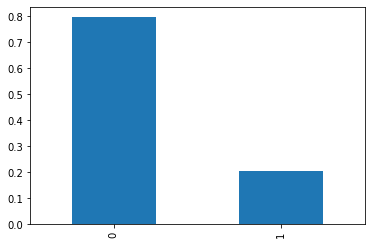

In [118]:
class_frequency = df['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Наблюдается дисбаланс классов. Положительный класс(1) меньше отрицательного(0) почти в четыре раза. 

0    0.912
1    0.088
dtype: float64


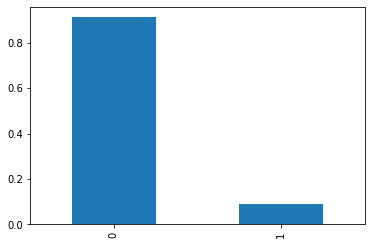

In [119]:
class_frequency_lr = predicted_valid_lr.value_counts(normalize=True)
print(class_frequency_lr)
class_frequency_lr.plot(kind='bar')

0    0.8905
1    0.1095
dtype: float64


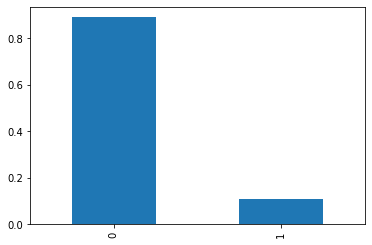

In [120]:
class_frequency_forest = predicted_valid_forest.value_counts(normalize=True)
print(class_frequency_forest)
class_frequency_forest.plot(kind='bar')

У моделей дисбаланс классов ещё выше.

Определим accuracy константной модели.

In [121]:
target_pred_constant = pd.Series([0]*len(target))
print("Accuracy модели:" , accuracy_score(target, target_pred_constant), '| ' "AUC-ROC:", roc_auc_score(target, target_pred_constant))

Accuracy модели: 0.7963 | AUC-ROC: 0.5


**Вывод:** Accuracy константной модели ниже, значит наши модели адекватны. Но значение F1 не достигает необходимого порога в 0.59 и наблюдается явный дисбаланс кассов, значит модели ещё могут быть улучшены.

## Борьба с дисбалансом

Попробуем сбалансировать классы с помощью аргумента class_weight.

In [122]:
model = LogisticRegression(random_state=12345, solver = 'liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid_lr = model.predict(features_valid)
f1 = f1_score(target_valid, predicted_valid_lr)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
print("F1:",f1, '| ' "AUC-ROC:", roc_auc)


F1: 0.48717948717948717 | AUC-ROC: 0.7636009775040982


In [123]:
model = RandomForestClassifier(n_estimators=100, max_depth=9, random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid_forest = model.predict(features_valid)
f1 = f1_score(target_valid, predicted_valid_forest)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
print("F1:",f1, '| ' "AUC-ROC:", roc_auc)

F1: 0.6267281105990784 | AUC-ROC: 0.8526016368354514


**Вывод:** Балансировка классов с помощью аргумента class_weight улучшает качество моделей. Особенно это заметно в модели линейной регрессии, значение F1 в ней выросло в 1.5 раза. 

Уменьшение выборки

In [124]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

In [125]:
model = LogisticRegression(random_state=12345, solver = 'liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid_downsampled_lr = model.predict(features_valid)
f1 = f1_score(target_valid, predicted_valid_downsampled_lr)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
print("F1:",f1,'| ' "AUC-ROC:", roc_auc)

F1: 0.42986425339366513 | AUC-ROC: 0.7588162885088828


In [126]:
model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid_downsampled_forest = model.predict(features_valid)
f1 = f1_score(target_valid, predicted_valid_downsampled_forest)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
print("F1:",f1, '| ' "AUC-ROC:", roc_auc)

F1: 0.46097111247695144 | AUC-ROC: 0.8370634954239984


**Вывод:** Уменьшение выборки ухудшает качество моделей. 

Посмотрим как влияет изменение порога на точность моделей

In [127]:
model = LogisticRegression(random_state=12345, solver = 'liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.5, 0.02):
        predicted_valid = probabilities_one_valid > threshold
        f1 = f1_score(target_valid, predicted_valid)
        roc_auc = roc_auc_score(target_valid, predicted_valid)
        print("Порог = {:.2f} | F1 = {:.3f}".format(
        threshold, f1))


Порог = 0.00 | F1 = 0.346
Порог = 0.02 | F1 = 0.348
Порог = 0.04 | F1 = 0.369
Порог = 0.06 | F1 = 0.391
Порог = 0.08 | F1 = 0.406
Порог = 0.10 | F1 = 0.423
Порог = 0.12 | F1 = 0.444
Порог = 0.14 | F1 = 0.464
Порог = 0.16 | F1 = 0.468
Порог = 0.18 | F1 = 0.482
Порог = 0.20 | F1 = 0.476
Порог = 0.22 | F1 = 0.482
Порог = 0.24 | F1 = 0.498
Порог = 0.26 | F1 = 0.497
Порог = 0.28 | F1 = 0.487
Порог = 0.30 | F1 = 0.484
Порог = 0.32 | F1 = 0.469
Порог = 0.34 | F1 = 0.461
Порог = 0.36 | F1 = 0.446
Порог = 0.38 | F1 = 0.418
Порог = 0.40 | F1 = 0.398
Порог = 0.42 | F1 = 0.390
Порог = 0.44 | F1 = 0.369
Порог = 0.46 | F1 = 0.367
Порог = 0.48 | F1 = 0.356


In [128]:
model = LogisticRegression(random_state=12345, solver = 'liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

threshold = 0.26
predicted_valid = probabilities_one_valid > threshold
f1 = f1_score(target_valid, predicted_valid)
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
print("F1:", f1)
print("AUC-ROC:", roc_auc)

F1: 0.4974515800203874
AUC-ROC: 0.7586408700754299


**Вывод:** Для логической регрессии увеличение порога до 0.26 увеличивает значение F1 до 0.497. Дальнейшее увеличение порога приводик к ухудшению результотов модели.

In [129]:
model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=12345)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.5, 0.02):
        predicted_valid = probabilities_one_valid > threshold
        f1 = f1_score(target_valid, predicted_valid)
        print("Порог = {:.2f} | F1 = {:.3f}".format(threshold, f1))

Порог = 0.00 | F1 = 0.346
Порог = 0.02 | F1 = 0.347
Порог = 0.04 | F1 = 0.380
Порог = 0.06 | F1 = 0.406
Порог = 0.08 | F1 = 0.434
Порог = 0.10 | F1 = 0.472
Порог = 0.12 | F1 = 0.506
Порог = 0.14 | F1 = 0.526
Порог = 0.16 | F1 = 0.553
Порог = 0.18 | F1 = 0.582
Порог = 0.20 | F1 = 0.604
Порог = 0.22 | F1 = 0.614
Порог = 0.24 | F1 = 0.618
Порог = 0.26 | F1 = 0.628
Порог = 0.28 | F1 = 0.637
Порог = 0.30 | F1 = 0.632
Порог = 0.32 | F1 = 0.640
Порог = 0.34 | F1 = 0.634
Порог = 0.36 | F1 = 0.627
Порог = 0.38 | F1 = 0.620
Порог = 0.40 | F1 = 0.608
Порог = 0.42 | F1 = 0.613
Порог = 0.44 | F1 = 0.601
Порог = 0.46 | F1 = 0.591
Порог = 0.48 | F1 = 0.583


In [130]:
model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=12345)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

threshold = 0.28
predicted_valid = probabilities_one_valid > threshold
f1 = f1_score(target_valid, predicted_valid)
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
print("F1:", f1)
print("AUC-ROC:", roc_auc)

F1: 0.6374133949191687
AUC-ROC: 0.8547142191762593


**Вывод:**  Для случайного леса увеличение порога до 0.28 увеличивает значение F1 до 0.637. Дальнейшее увеличение порога приводик к ухудшению результотов модели.

Определим наилучшие параметры n_estimators и max_depth для модели случайного леса.

In [131]:
accur=0
est=0
dep=0
f = 0
for estim in range(1, 100, 5): 
    for depth in range(1, 12):
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=estim, max_depth=depth)
        model_forest.fit(features_train, target_train)
        predicted_valid_forest = model_forest.predict(features_valid)
        accuracy = accuracy_score(target_valid, predicted_valid_forest)
        f1 = f1_score(target_valid, predicted_valid)
        if accuracy > accur:
            accur=accuracy
            est=estim
            dep=depth
            f=f1
print('Параметры наилучшей модели на валидационной выборке: ' "n_estimators=", est, "| " "depth=", dep, "| " "accuracy:", accur, "| " "F1:", f)

Параметры наилучшей модели на валидационной выборке: n_estimators= 36 | depth= 9 | accuracy: 0.8675 | F1: 0.6374133949191687


In [141]:
model_forest = RandomForestClassifier(random_state=12345, n_estimators=36, max_depth=9)
model_forest.fit(features_train, target_train)
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC-ROC:", roc_auc)

AUC-ROC: 0.8504875422667691


**Вывод:** Были проверены три способа борьбы с дисбалансом классов. Наилучший результат показало увеличение порога до 0.34 в модели случайный лес.
Так же были определены наилучшие параметры  n_estimators и  depth для этой модели.
Осталось проверить модель с наилучшими параметрями на тестовой выборке.
    

## Тестирование модели

In [142]:
model_final = RandomForestClassifier(n_estimators=36, max_depth=9, random_state=12345)
model_final.fit(features_train, target_train)
probabilities_valid = model_final.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

threshold = 0.28
predicted_valid = probabilities_one_valid > threshold
f1 = f1_score(target_test, predicted_valid)
roc_auc = roc_auc_score(target_test, probabilities_one_valid)
print("F1:", f1)
print("AUC-ROC:", roc_auc)

F1: 0.6234357224118316
AUC-ROC: 0.8526348769471315


Значение F1 модели на тестовой выборке выше необходимого порога в 0.59. AUC-ROC на идеально, но выше значения случайной модели(0.5). Что можно считать ещё одним критерием адекватности обученной модели.

**Общий Вывод:**

В ходе исследования оттока клиентов «Бета-Банка» данные были подготовлены для обучения моделей. Удалены лишние столбцы. Заполнены пропуски. Произведено преобразование категориальные признаки в численные с помощью техники One-Hot Encoding. 
Разбил датасет на 3 выборки - обучающую, валидационную и тестовую.
Исследовал баланс классов - они были несбалансированы. 
Применил три способа борбы с дисбалансом - аргумент class_weight, уменьшение выборки и изменение порога. Лучшие результаты показало изменение порога.
Выявил наилучшие значения n_estimators и max_depth для модели случайного леса.
Обучил финальную модель с наилучшими параметрами. Достиг значения F1 = 0.601 на тестовой выборке, что выше необходимого нам значения в 0.59. 